# Определение возраста покупателей

## Исследовательский анализ данных

In [24]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [10]:
#посмотрим размер датасета
labels.shape

(7591, 2)

In [11]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [12]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Данные полны, видим название файлов фото и возраст человека на данных фотою

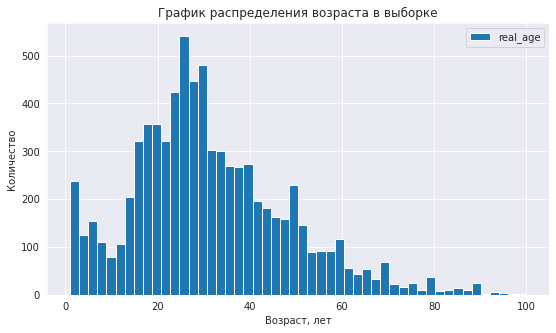

In [15]:
sns.set_style("dark")
labels.plot(kind='hist',figsize=(9,5),bins=50, grid=True)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


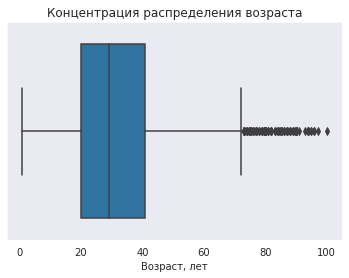

In [19]:
sns.boxplot(labels["real_age"])
plt.title('Концентрация распределения возраста')
plt.xlabel('Возраст, лет')
plt.show()

Мы видим что большинство данных собраны на людях возрастом от 20 до 40 лет с пиком 30 лет.

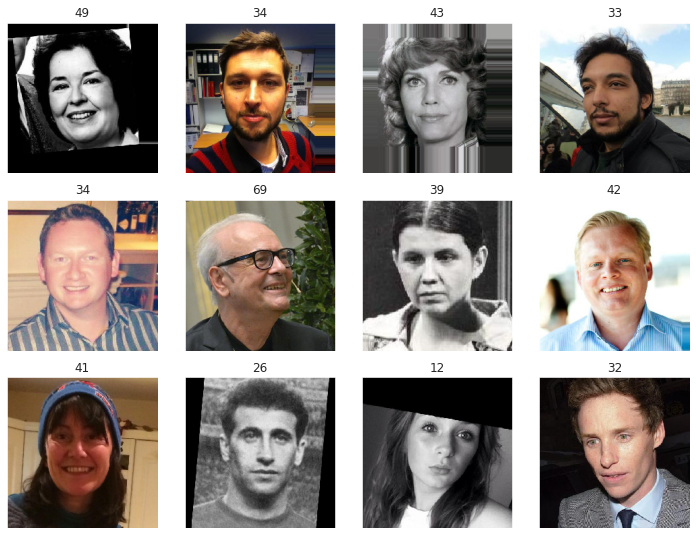

In [22]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [23]:
features[0].shape

(224, 224, 3)

Перед нами изображения людей.Есть фотографии, которые покрутили вокруг своей оси. Размер фото 224x224, цветное.

# Вывод
В нашем распоряжении датасет с размеченными фотографиями в количестве 7591 шт и размером 224х224, этого количества достаточно для того, чтобы провести обучение нашей модели без заморозки основного слоя сети. Среди них много повернутых изображений по горизонтали и поэтому мы должны добавить изображения с увеличенным вращением в тренировочную выборку.
По гистограмме распределения семплов мы можем увидеть нормальное распределение возростных данных со скосом вправо. При этом выделяются пиковые года в области дат, таких как: первого года жизни, 18 лет, 30 лет, 40, 60 и т.д. В нашем датасете мы имеем преобладающее большинство размеченных фотографий с возрастом от 20 до 40 лет с пиковым значением в 30 лет. Возможно такое распределение связано с тем, что молодые люди до 30 лет ведут активный образ жизни, делая много разных фотографий. Люди после 30 лет ведут более размеренную жизнь,желание сделать фото, становится всё меньше. Сделует что наша модель будет делать более точные прогнозы на фотографиях людей в возрасте от 20 до 40 лет.

## Обучение модели

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 62s - loss: 209.3883 - mae: 11.0315 - val_loss: 322.0773 - val_mae: 13.2992

Epoch 2/10

356/356 - 52s - loss: 138.8230 - mae: 9.0138 - val_loss: 265.2576 - val_mae: 12.2220

Epoch 3/10

356/356 - 54s - loss: 110.6103 - mae: 8.0003 - val_loss: 188.1182 - val_mae: 10.8467

Epoch 4/10

356/356 - 55s - loss: 93.6728 - mae: 7.3805 - val_loss: 154.1495 - val_mae: 9.6483

Epoch 5/10

356/356 - 57s - loss: 86.9723 - mae: 7.1254 - val_loss: 111.7482 - val_mae: 8.1293

Epoch 6/10

356/356 - 40s - loss: 70.7031 - mae: 6.4628 - val_loss: 108.0537 - val_mae: 7.7700

Epoch 7/10

356/356 - 40s - loss: 57.5107 - mae: 5.8324 - val_loss: 106.1195 - val_mae: 7.7162

Epoch 8/10

356/356 - 52s - loss: 47.6368 - mae: 5.3033 - val_loss: 177.9648 - val_mae: 10.3832

Epoch 9/10

356/356 - 56s - loss: 43.3984 - mae: 5.1114 - val_loss: 123.9541 - val_mae: 8.1649

Epoch 10/10

356/356 - 58s - loss: 35.2548 - mae: 4.5897 - val_loss: 113.8672 - val_mae: 7.7786

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 113.8672 - mae: 7.7786

Test MAE: 7.7786

## Анализ обученной модели

Модель ошибается в среднем на 7.7 года, следовательно, модель соответствует поставленной задаче сетевого супермаркета  по пункту анализа покупок и предложения товаров, которые могут заинтересовать покупателей, но для контроля кассиров по продаже товаров непредназначенных для несовершеннолетних данная система не может быть внедрена, так как ошибка в 7.7 лет существенно влияет на данный фактор.
Для лучшего результата необходимо добавить в выборку больше данных в сегменте людей от 30 и более.

С такими параметрами мы протестировали нашу модель на 10 эпохах и уже 6 на эпохе обучения на тестовых данных, она достигла значения по метрике МАЕ равное 7.7, что меньше 8. Мы можем ограничить модель 6 эпохами, это позволит на 40% сократить время обучения модели.



